# Ensemble methods

In [165]:
import warnings
import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score, make_scorer,
                            classification_report, confusion_matrix, plot_confusion_matrix)

# Importing the cleaned data
df = pd.read_csv('stroke_clean.csv', index_col='id')
print('Dataset: ', data.shape)
df

ImportError: cannot import name 'plot_confusion_matrix'

In [156]:
# Do a train-test split
x = np.array(df.loc[:, data.columns != 'stroke'])
y = np.array(df['stroke'])
test_size = 0.3

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size, random_state = 41)

# Scaling the data
#scaler = StandardScaler()
#x_train = scaler.fit_transform(x_train)
#x_test = scaler.transform(x_test)

# Define different scores to evaluate the models
scoring = {'accuracy': make_scorer(accuracy_score),
           'precision': make_scorer(precision_score),
           'f1': make_scorer(f1_score),
           'recall': make_scorer(recall_score)}

(3435, 17)

(array([ 1.,  0.,  1.,  4.,  7., 21., 33., 26., 36., 80.]),
 array([14. , 20.8, 27.6, 34.4, 41.2, 48. , 54.8, 61.6, 68.4, 75.2, 82. ]),
 <BarContainer object of 10 artists>)

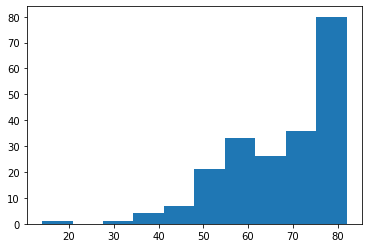

In [113]:
# Quick EDA
# Stroke = 1
# Not stroke = 0

# Dataset is very skewed, in more than one way
# We have more women than men in the dataset
# We have more people without strokes than with strokes

# Seems like an almost exponential chance of getting a stroke as you become older, based purely on data
plt.hist(df[df.stroke == 1].age)

(array([422., 355., 431., 468., 572., 552., 637., 500., 335., 427.]),
 array([8.0000e-02, 8.2720e+00, 1.6464e+01, 2.4656e+01, 3.2848e+01,
        4.1040e+01, 4.9232e+01, 5.7424e+01, 6.5616e+01, 7.3808e+01,
        8.2000e+01]),
 <BarContainer object of 10 artists>)

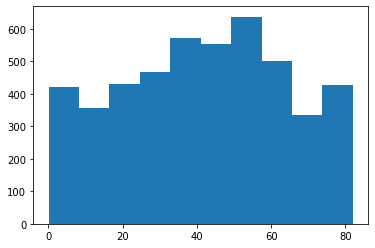

In [112]:
# More even distribution for not having a stroke
plt.hist(df[df.stroke == 0].age)

(array([4699.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         209.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

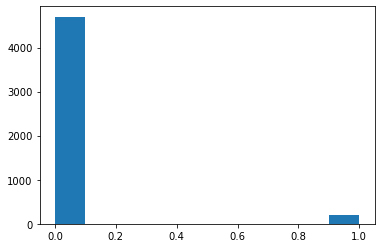

In [166]:
# Very skrewed in favor of not having a stroke.
# It is going to be very hard to predict the people having a stroke
# We cannot use accuracy, as this will give us a good result by simply classifying everyone as not getting a stroke
plt.hist(df.stroke)

In [167]:
print("Percentage of stroke examples in dataset: ", df[df.stroke == 1].shape[0]/df.shape[0])
print("Percentage of non-stroke examples in dataset: ", df[df.stroke == 0].shape[0]/df.shape[0])

Percentage of stroke examples in dataset:  0.04258353708231459
Percentage of non-stroke examples in dataset:  0.9574164629176855


### Decision tree

Implement a simple decision tree to test the GridSeachCV and get a baseline error.

In [171]:
warnings.filterwarnings('ignore')  # "error", "ignore", "always", "default", "module" or "once"

parameters = {'criterion': ('gini', 'entropy'),     # Function to measure quality of split
              'max_depth': range(1, 10, 1),          # The maximum depth of the tree
              'min_samples_split': range(2, 10, 1),  # The minimum number of samples required to split an internal node
              'min_samples_leaf': range(1, 10, 1)}   # The minimum number of samples required to be at a leaf node

clf = GridSearchCV(estimator = DecisionTreeClassifier(random_state = 41),
                   param_grid = parameters,
                   scoring = scoring,
                   cv = 5,
                   refit = 'f1') # accuracy, precision, recall or f1

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

warnings.filterwarnings('always')

{'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 5, 'min_samples_split': 2}


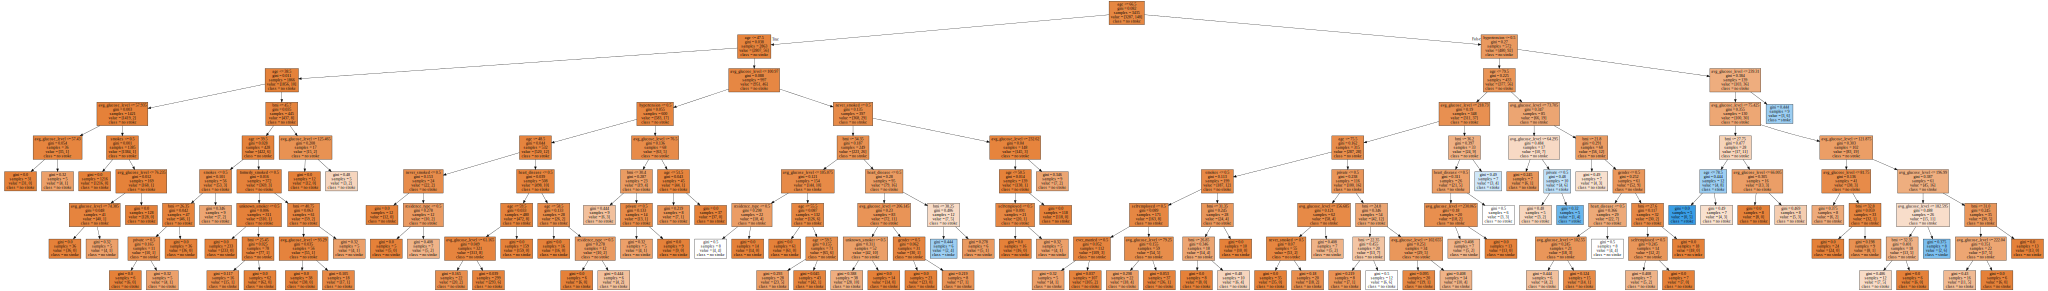

In [172]:
# Add best params into the function

tree = DecisionTreeClassifier(**best_params)
#tree = DecisionTreeClassifier(max_depth = 2)
a = tree.fit(x_train, y_train)
y_pred = a.predict(x_test)

display(graphviz.Source(export_graphviz(a, feature_names = data.columns[:-1], filled = True, class_names = ("no stroke", "stroke"))))

In [173]:
print("Training errors:")
train_pred = a.predict(x_train)
tn, fp, fn, tp = confusion_matrix(y_train, train_pred).ravel()
print("tn: ", tn)
print("fp: ", fp)
print("fn: ", fn)
print("tp: ", tp)
cm = confusion_matrix(y_train, train_pred)
print(cm)
print()

print("Test errors:")
cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
print()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

Training errors:
tn:  3276
fp:  11
fn:  119
tp:  29
[[3276   11]
 [ 119   29]]

Test errors:
Confusion matrix:
[[1395   17]
 [  59    2]]

accuracy:  0.9484046164290564
precision:  0.10526315789473684
recall:  0.03278688524590164
f1:  0.05


We have too many false negatives. Dangerous! Maybe use "recall" as measure with this dataset? Or f1? Accuracy is good in cases where we have equal size classes and false negatives and false positives are of equal importance. Prediction is good when we want to minimize the cases of true positives. Recall is good when we want to minimize the cases of false negatives. F1 takes into account both precision and recall. In our case it might be better to predict that someone will have a stroke even if that will not be the case, compared to the opposite.

\begin{align*}
    \text{accuracy} = \frac{\text{tp + tn}}{\text{tp + tn + fn + fp}}
\end{align*}

\begin{align*}
    \text{precision} = \frac{\text{tp}}{\text{tp + fp}}
\end{align*}

\begin{align*}
    \text{recall} = \frac{\text{tp}}{\text{tp + fn}}
\end{align*}

\begin{align*}
    \text{f1} = \frac{2\cdot \text{precision} \cdot \text{recall}}{\text{precision + recall}}
\end{align*}

Accuracy is around $95\%$ with a single deicison tree. If we do grid search with regards to accuracy, all the other measures becomes zero.

Future: add some plots of the hyperparameter tuning process maybe?

### Random Forest

Try to fit a random forest model to the stroke classification problem. Use cross-validation grid search to find the optimal parameters.

In [187]:
warnings.filterwarnings('ignore')

parameters = {'n_estimators': [1, 5, 7, 10, 20, 30, 50, 100]}
              #'max_depth': range(1, 3, 1)}

clf = GridSearchCV(estimator = RandomForestClassifier(random_state=41,
                                                      criterion = 'gini',
                                                      bootstrap=True,
                                                      oob_score=False),
                  param_grid = parameters,
                  scoring = scoring,
                  cv = 5,
                  refit = 'recall',
                  return_train_score = True)
                  #verbose = 2)

clf = clf.fit(x_train, y_train)
results = clf.cv_results_
best_params = clf.best_params_
print(best_params)

warnings.filterwarnings('always')

{'n_estimators': 1}


In [188]:
# Instantiate model with 1000 decision trees
#rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, max_depth = 2)
rf = RandomForestClassifier(**best_params)
a = rf.fit(x_train, y_train)
y_pred = a.predict(x_test)

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:")
print(cm)
print()

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("accuracy: ", accuracy)
print("precision: ", precision)
print("recall: ", recall)
print("f1: ", f1)

Confusion matrix:
[[1366   46]
 [  54    7]]

accuracy:  0.9321113374066531
precision:  0.1320754716981132
recall:  0.11475409836065574
f1:  0.12280701754385966


[  1.   5.   7.  10.  20.  30.  50. 100.]


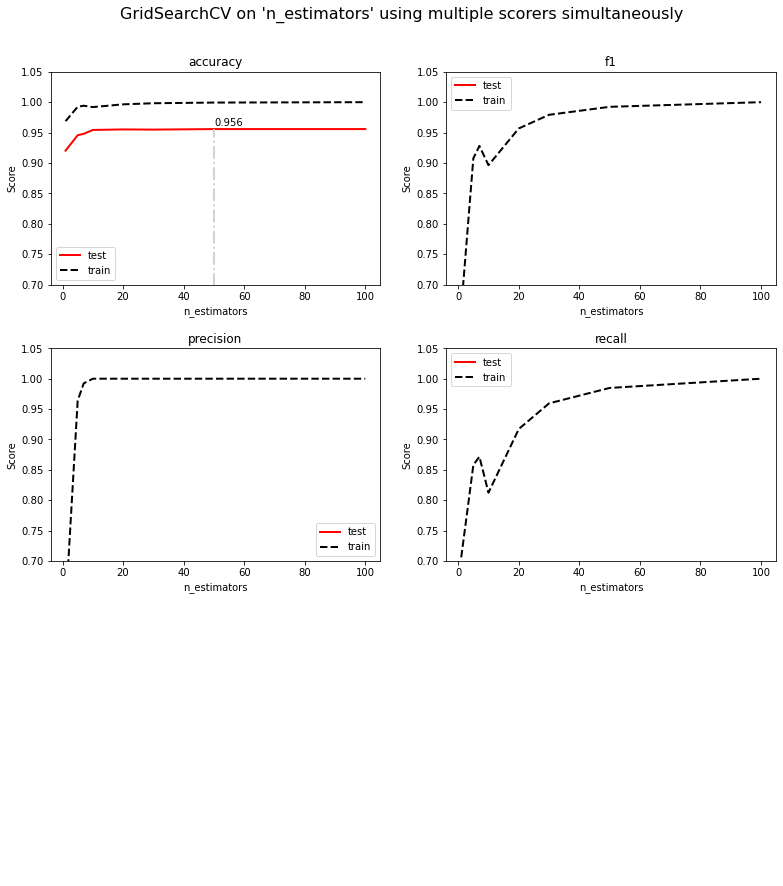

In [189]:
# Plot the development of adding more trees to the RF classifier

hyperparameter = 'n_estimators'
#params = {'n_estimators': [1, 5, 10, 50, 100, 200, 300, 400, 500]}

plt.figure(figsize=(13, 9))

# Get the regular numpy array from the MaskedArray
X_axis = np.array(results[f'param_{hyperparameter}'].data, dtype=float)
print(X_axis)
num = 1
for scorer in sorted(scoring):
    plt.subplot(2, 2, num)
    for sample, style in (('test', '-'), ('train', '--')):
        sample_score_mean = results[f'mean_{sample}_{scorer}']
        #sample_score_std = results[f'std_{sample}_{scorer}']

        plt.plot(X_axis, sample_score_mean, style,
                     linewidth=2,
                     color='black' if sample == 'train' else 'red',
                     label=f'{sample}')

    best_index = np.nonzero(results[f'rank_test_{scorer}'] == 1)[0][0]
    best_score = results[f'mean_test_{scorer}'][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    plt.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', linewidth=2, color='lightgray', ms=10)

    # Annotate the best score for that scorer
    plt.annotate("%0.3f" % best_score,
                (X_axis[best_index], best_score + 0.005))
    num += 1
    plt.ylim(0.7, 1.05)
    plt.title(scorer)
    plt.xlabel(hyperparameter)
    plt.ylabel("Score")
    plt.legend()

plt.suptitle(f"GridSearchCV on '{hyperparameter}' using multiple scorers simultaneously", fontsize=16)
plt.grid(False)
plt.subplots_adjust(hspace=0.3)
plt.show()

In [142]:
#results["mean_test_accuracy"]
#results["std_test_accuracy"]
results["rank_test_accuracy"]

array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, 91,
       91, 93,  1,  1,  1,  1,  1,  1,  1,  1,  1, 93, 93, 93,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])